
Faces recognition example using eigenfaces and SVMs

The dataset used in this example is a preprocessed excerpt of the
"Labeled Faces in the Wild", aka LFW_:

  http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz (233MB)

  .. _LFW: http://vis-www.cs.umass.edu/lfw/

  original source: http://scikit-learn.org/stable/auto_examples/applications/face_recognition.html


Total dataset size:
n_samples: 1217
n_features: 1850
n_classes: 6
Extracting the top 150 eigenfaces from 912 faces
done in 2.850s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.121s
Fitting the classifier to the training set
done in 20.669s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.005, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Predicting the people names on the testing set
done in 0.065s
                   precision    recal

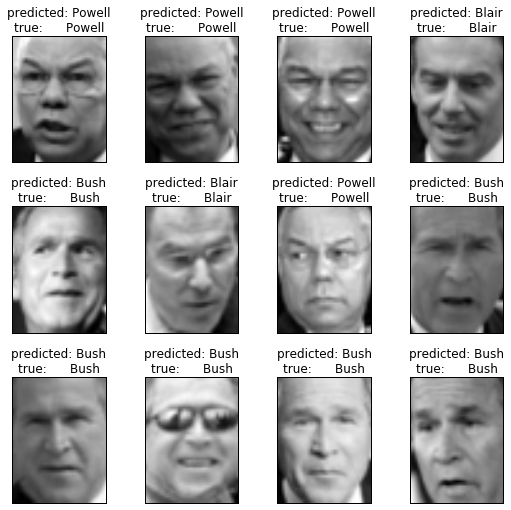

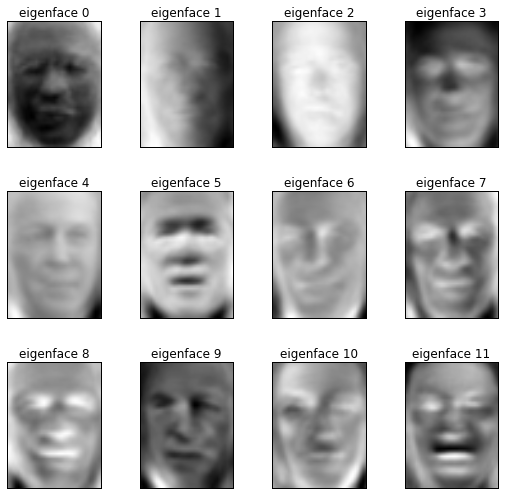

In [1]:
"""
===================================================
Faces recognition example using eigenfaces and SVMs
===================================================

The dataset used in this example is a preprocessed excerpt of the
"Labeled Faces in the Wild", aka LFW_:

  http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz (233MB)

  .. _LFW: http://vis-www.cs.umass.edu/lfw/

  original source: http://scikit-learn.org/stable/auto_examples/applications/face_recognition.html

"""

%matplotlib inline

print __doc__

from time import time
import logging
import pylab as pl
import numpy as np

from sklearn.cross_validation import train_test_split
from sklearn.datasets import fetch_lfw_people
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import RandomizedPCA
from sklearn.svm import SVC

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')


###############################################################################
# Download the data, if not already on disk and load it as numpy arrays
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape
np.random.seed(42)

# for machine learning we use the data directly (as relative pixel
# position info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print "Total dataset size:"
print "n_samples: %d" % n_samples
print "n_features: %d" % n_features
print "n_classes: %d" % n_classes


###############################################################################
# Split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

###############################################################################
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 150

print "Extracting the top %d eigenfaces from %d faces" % (n_components, X_train.shape[0])
t0 = time()
pca = RandomizedPCA(n_components=n_components, whiten=True).fit(X_train)
print "done in %0.3fs" % (time() - t0)

eigenfaces = pca.components_.reshape((n_components, h, w))

print "Projecting the input data on the eigenfaces orthonormal basis"
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print "done in %0.3fs" % (time() - t0)


###############################################################################
# Train a SVM classification model

print "Fitting the classifier to the training set"
t0 = time()
param_grid = {
         'C': [1e3, 5e3, 1e4, 5e4, 1e5],
          'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
          }
# for sklearn version 0.16 or prior, the class_weight parameter value is 'auto'
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(X_train_pca, y_train)
print "done in %0.3fs" % (time() - t0)
print "Best estimator found by grid search:"
print clf.best_estimator_


###############################################################################
# Quantitative evaluation of the model quality on the test set

print "Predicting the people names on the testing set"
t0 = time()
y_pred = clf.predict(X_test_pca)
print "done in %0.3fs" % (time() - t0)

print classification_report(y_test, y_pred, target_names=target_names)
print confusion_matrix(y_test, y_pred, labels=range(n_classes))


###############################################################################
# Qualitative evaluation of the predictions using matplotlib

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    pl.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    pl.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        pl.subplot(n_row, n_col, i + 1)
        pl.imshow(images[i].reshape((h, w)), cmap=pl.cm.gray)
        pl.title(titles[i], size=12)
        pl.xticks(())
        pl.yticks(())


# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                         for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

# plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

pl.show()


In [2]:
pca.components_[0]

array([ -1.37606648e-05,  -1.46618819e-05,  -1.83720307e-05, ...,
        -7.72723957e-06,  -7.55809164e-06,  -5.98110670e-06])

In [3]:
pca.explained_variance_ratio_

array([ 0.1756148 ,  0.15863263,  0.07318608,  0.06090466,  0.0517291 ,
        0.03160737,  0.02576067,  0.02138073,  0.02082764,  0.01948133,
        0.01633398,  0.01437693,  0.01234296,  0.01121052,  0.01047367,
        0.01003185,  0.00935521,  0.00880151,  0.00819121,  0.00757657,
        0.00696916,  0.00683109,  0.00645415,  0.00609712,  0.00553017,
        0.00538439,  0.00521731,  0.00491494,  0.00469909,  0.00441259,
        0.00404316,  0.00383722,  0.00376174,  0.00361714,  0.00358961,
        0.0034368 ,  0.00331051,  0.00310258,  0.00301176,  0.00280817,
        0.00276717,  0.00272828,  0.00264834,  0.00258634,  0.0025044 ,
        0.00243234,  0.00235752,  0.00232155,  0.00222539,  0.00212546,
        0.00211465,  0.0020586 ,  0.00199162,  0.00197074,  0.00187519,
        0.00184564,  0.00180622,  0.00177799,  0.00175082,  0.00166473,
        0.00163962,  0.00161744,  0.00158007,  0.00157085,  0.00153392,
        0.00151784,  0.00147655,  0.00144971,  0.00142257,  0.00


Faces recognition example using eigenfaces and SVMs

The dataset used in this example is a preprocessed excerpt of the
"Labeled Faces in the Wild", aka LFW_:

  http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz (233MB)

  .. _LFW: http://vis-www.cs.umass.edu/lfw/

  original source: http://scikit-learn.org/stable/auto_examples/applications/face_recognition.html


Total dataset size:
n_samples: 1217
n_features: 1850
n_classes: 6
Extracting the top 100 eigenfaces from 912 faces
done in 0.513s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.089s
Fitting the classifier to the training set
done in 15.375s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.005, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Predicting the people names on the testing set
done in 0.045s
                   precision    recal

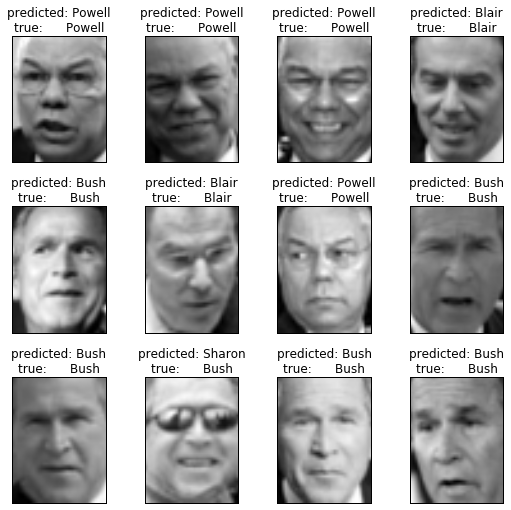

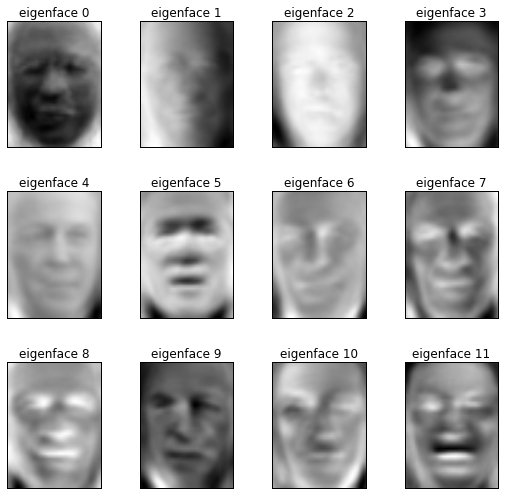

In [5]:
"""
===================================================
Faces recognition example using eigenfaces and SVMs
===================================================

The dataset used in this example is a preprocessed excerpt of the
"Labeled Faces in the Wild", aka LFW_:

  http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz (233MB)

  .. _LFW: http://vis-www.cs.umass.edu/lfw/

  original source: http://scikit-learn.org/stable/auto_examples/applications/face_recognition.html

"""

%matplotlib inline

print __doc__

from time import time
import logging
import pylab as pl
import numpy as np

from sklearn.cross_validation import train_test_split
from sklearn.datasets import fetch_lfw_people
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import RandomizedPCA
from sklearn.svm import SVC

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')


###############################################################################
# Download the data, if not already on disk and load it as numpy arrays
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape
np.random.seed(42)

# for machine learning we use the data directly (as relative pixel
# position info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print "Total dataset size:"
print "n_samples: %d" % n_samples
print "n_features: %d" % n_features
print "n_classes: %d" % n_classes


###############################################################################
# Split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

###############################################################################
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 100

print "Extracting the top %d eigenfaces from %d faces" % (n_components, X_train.shape[0])
t0 = time()
pca = RandomizedPCA(n_components=n_components, whiten=True).fit(X_train)
print "done in %0.3fs" % (time() - t0)

eigenfaces = pca.components_.reshape((n_components, h, w))

print "Projecting the input data on the eigenfaces orthonormal basis"
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print "done in %0.3fs" % (time() - t0)


###############################################################################
# Train a SVM classification model

print "Fitting the classifier to the training set"
t0 = time()
param_grid = {
         'C': [1e3, 5e3, 1e4, 5e4, 1e5],
          'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
          }
# for sklearn version 0.16 or prior, the class_weight parameter value is 'auto'
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(X_train_pca, y_train)
print "done in %0.3fs" % (time() - t0)
print "Best estimator found by grid search:"
print clf.best_estimator_


###############################################################################
# Quantitative evaluation of the model quality on the test set

print "Predicting the people names on the testing set"
t0 = time()
y_pred = clf.predict(X_test_pca)
print "done in %0.3fs" % (time() - t0)

print classification_report(y_test, y_pred, target_names=target_names)
print confusion_matrix(y_test, y_pred, labels=range(n_classes))


###############################################################################
# Qualitative evaluation of the predictions using matplotlib

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    pl.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    pl.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        pl.subplot(n_row, n_col, i + 1)
        pl.imshow(images[i].reshape((h, w)), cmap=pl.cm.gray)
        pl.title(titles[i], size=12)
        pl.xticks(())
        pl.yticks(())


# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                         for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

# plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

pl.show()



Faces recognition example using eigenfaces and SVMs

The dataset used in this example is a preprocessed excerpt of the
"Labeled Faces in the Wild", aka LFW_:

  http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz (233MB)

  .. _LFW: http://vis-www.cs.umass.edu/lfw/

  original source: http://scikit-learn.org/stable/auto_examples/applications/face_recognition.html


Total dataset size:
n_samples: 1217
n_features: 1850
n_classes: 6
Extracting the top 300 eigenfaces from 912 faces
done in 1.258s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.123s
Fitting the classifier to the training set
done in 46.436s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.0005, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Predicting the people names on the testing set
done in 0.118s
                   precision    reca

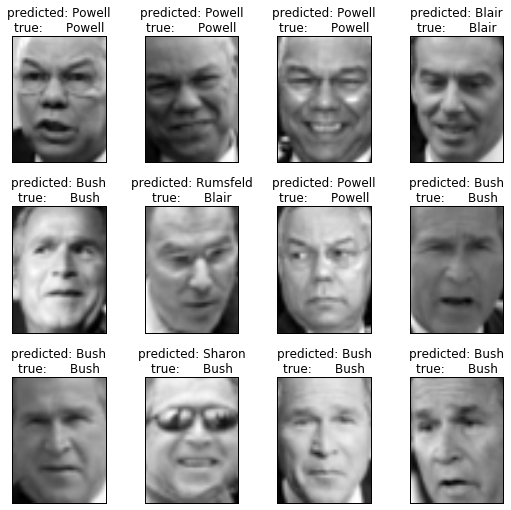

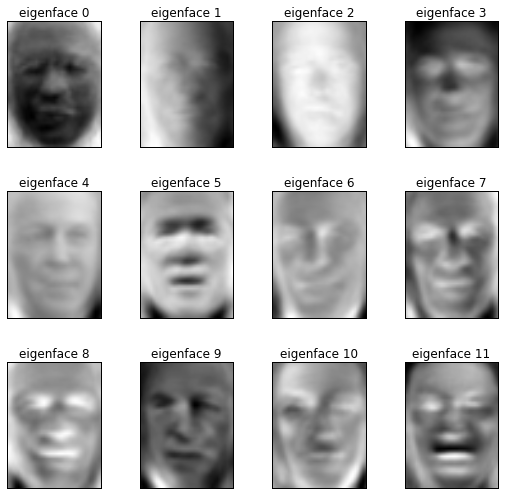

In [6]:
"""
===================================================
Faces recognition example using eigenfaces and SVMs
===================================================

The dataset used in this example is a preprocessed excerpt of the
"Labeled Faces in the Wild", aka LFW_:

  http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz (233MB)

  .. _LFW: http://vis-www.cs.umass.edu/lfw/

  original source: http://scikit-learn.org/stable/auto_examples/applications/face_recognition.html

"""

%matplotlib inline

print __doc__

from time import time
import logging
import pylab as pl
import numpy as np

from sklearn.cross_validation import train_test_split
from sklearn.datasets import fetch_lfw_people
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import RandomizedPCA
from sklearn.svm import SVC

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')


###############################################################################
# Download the data, if not already on disk and load it as numpy arrays
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape
np.random.seed(42)

# for machine learning we use the data directly (as relative pixel
# position info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print "Total dataset size:"
print "n_samples: %d" % n_samples
print "n_features: %d" % n_features
print "n_classes: %d" % n_classes


###############################################################################
# Split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

###############################################################################
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 300

print "Extracting the top %d eigenfaces from %d faces" % (n_components, X_train.shape[0])
t0 = time()
pca = RandomizedPCA(n_components=n_components, whiten=True).fit(X_train)
print "done in %0.3fs" % (time() - t0)

eigenfaces = pca.components_.reshape((n_components, h, w))

print "Projecting the input data on the eigenfaces orthonormal basis"
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print "done in %0.3fs" % (time() - t0)


###############################################################################
# Train a SVM classification model

print "Fitting the classifier to the training set"
t0 = time()
param_grid = {
         'C': [1e3, 5e3, 1e4, 5e4, 1e5],
          'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
          }
# for sklearn version 0.16 or prior, the class_weight parameter value is 'auto'
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(X_train_pca, y_train)
print "done in %0.3fs" % (time() - t0)
print "Best estimator found by grid search:"
print clf.best_estimator_


###############################################################################
# Quantitative evaluation of the model quality on the test set

print "Predicting the people names on the testing set"
t0 = time()
y_pred = clf.predict(X_test_pca)
print "done in %0.3fs" % (time() - t0)

print classification_report(y_test, y_pred, target_names=target_names)
print confusion_matrix(y_test, y_pred, labels=range(n_classes))


###############################################################################
# Qualitative evaluation of the predictions using matplotlib

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    pl.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    pl.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        pl.subplot(n_row, n_col, i + 1)
        pl.imshow(images[i].reshape((h, w)), cmap=pl.cm.gray)
        pl.title(titles[i], size=12)
        pl.xticks(())
        pl.yticks(())


# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                         for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

# plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

pl.show()
